In [11]:
import sys        
sys.path.append('/home/huyentn2/project/nano_count/segmentation_unet/')
import os
from dataset import *
from utils import *
import torch.nn.functional  as F
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from scipy.ndimage import label
from utils import get_num_NP
import matplotlib.pyplot as plt
import json


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=1, n_classes= 2, bilinear= False)
model = model.to(memory_format=torch.channels_last)
model = torch.nn.DataParallel(model).cuda()

checkpoint = torch.load("/home/huyentn2/project/nano_count/segmentation_unet/checkpoints_7_4/fold0/checkpoint_epoch15.pth")

model.load_state_dict(checkpoint)
model.to(device=device)

input_dir = "/home/huyentn2/project/nano_count/segmentation_unet/data/img_patch/"
save_dir = "/home/huyentn2/project/nano_count/segmentation_unet"

out_files = "/home/huyentn2/project/nano_count/segmentation_unet/checkpoints_7_4/save_result/binary_pred/fold0/"
files = os.listdir(out_files)


In [13]:
js  = '/home/huyentn2/project/nano_count/segmentation_unet/inference/gt_all_count.json'

with open(js, 'r') as fp:
    gt_count = json.load(fp)

DIFFERENT BINARY THRESHOLD

In [14]:
count_GT = []

for id in range(len(files)):
    input_file = input_dir + files[id]

    if files[id] in list(gt_count.keys()):
        count_GT.append(gt_count[files[id]])

In [15]:
min_dist = 10
max_fil_thr = 120
bin_thr_range = np.arange(.5,.7,.05)
range_rad = (10,200)
type_count = "3" # 4

def plot(type_count):
    count_3 = np.zeros((len(bin_thr_range), len(files)))

    for id in range(len(files)):
        input_file = input_dir + files[id]
        mask_pred = eval_single_count(input_file,
                    save_dir,
                    model,
                    device,
                    img_scale=1.0,)

        # count_list = []
        for i in range(len(bin_thr_range)):
            bin_thr = bin_thr_range[i]
            num_PN = get_num_NP(mask_pred, min_dist=None, max_fil_thr =None, bin_thr = bin_thr,  range_rad= range_rad, type_count= type_count)
            # count_list.append(num_PN)
            count_3[i, id] = num_PN

    count_3.shape

    fig = plt.figure()
    ax = plt.axes()
    x = np.linspace(0, len(count_GT)-1, len(count_GT))
    ax.plot(x, count_GT, 'r')
    for i in range(len(bin_thr_range)):
        # if i in [1,3,5,8]:
        ax.plot(x, count_3[i,:])

    err_mat = np.zeros((len(bin_thr_range)))
    for j in range(len(bin_thr_range)):
        err_mat[j] = np.sum(np.abs(count_3[j,:] - count_GT))

    return err_mat, count_3

    

In [ ]:
err_mat, count_3 = plot("4")

In [85]:
err_mat/35

array([15.88571429, 17.8       , 27.62857143, 47.34285714])

In [60]:
len(err_mat)
err_mat

array([ 525.,  806., 1903., 1951., 1951.])

In [ ]:
# fig = plt.figure()
# ax = plt.axes()
# x = np.linspace(0, len(count_GT)-1, len(count_GT))
# ax.plot(x, count_GT, 'r')
# for i in range(len(bin_thr_range)):
#     if i in [1,3,5,8]:
#         ax.plot(x, count_3[i,:])

/home/huyentn2/.conda/envs/nano/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/huyentn2/.conda/envs/nano/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/huyentn2/.conda/envs/nano/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/huyentn2/.conda/envs/nano/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/huyentn2/.conda/envs/nano/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, ou

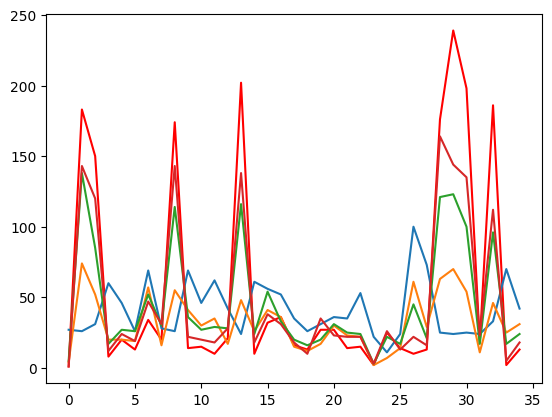

In [44]:
plot("3")

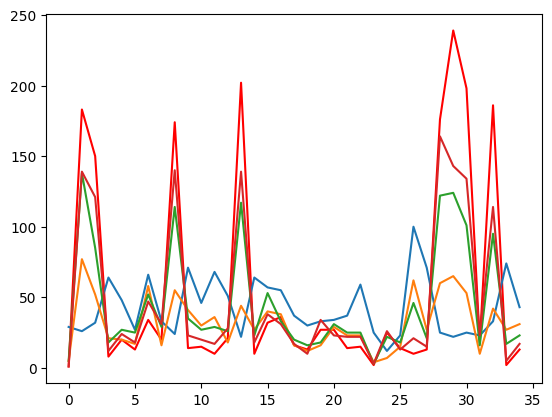

In [45]:
plot("4")

PLOT WITH DIFFERENT COUNTING METHOD

In [3]:
min_dist = 10
max_fil_thr = 120
bin_thr_ = 0.5
range_rad = (10,200)
# type_count = "3" # 4
labels = ["0", "1", "2", "3", "4"]

def plot_all_meth():
    count_ = np.zeros((5, len(files)))

    for id in range(len(files)):
        input_file = input_dir + files[id]
        mask_pred = eval_single_count(input_file,
                    save_dir,
                    model,
                    device,
                    img_scale=1.0,)

        # count_list = []
        for i in range(5):
            type_count = str(i)
            num_PN = get_num_NP(mask_pred, min_dist=min_dist, max_fil_thr =max_fil_thr, bin_thr = bin_thr_,  range_rad= range_rad, type_count= type_count)
            # count_list.append(num_PN)
            count_[i, id] = num_PN

    count_.shape

    err_mat = np.zeros((5))
    for j in range(5):
        err_mat[j] = np.sum(np.abs(count_[j,:] - count_GT))


    fig = plt.figure()
    ax = plt.axes()
    x = np.linspace(0, len(count_GT)-1, len(count_GT))
    ax.plot(x, count_GT, 'r', label="ground_truth")
    for i in range(5):
        # if i in [1,3,5,8]:
        ax.plot(x, count_[i,:], label= labels[i] + ": " + "{0:.2f}".format(err_mat[i]/len(files)), linestyle='dashed')
        ax.legend()


    return err_mat, count_

    

/home/huyentn2/.conda/envs/nano/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


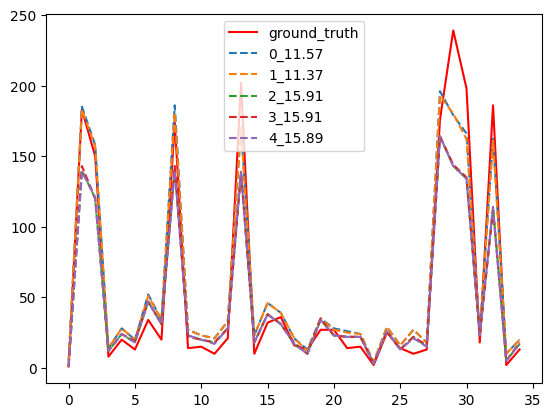

In [114]:
err_mat_, count_ =plot_all_meth()

In [97]:
err_mat_/35

array([11.57142857, 11.37142857, 15.91428571, 15.91428571, 15.88571429])

EVALUATION: NUM_COUNT_EACH_IMG/ TOTAL_GT_IMG

GET PLOT OF ALL FOLDS

In [8]:
min_dist = 10
max_fil_thr = 120
bin_thr_ = 0.5
range_rad = (10,200)
# type_count = "3" # 4
labels = ["0", "1", "2", "3", "4"]

def plot_all_meth(input_dir, save_dir):

    files = os.listdir(input_dir)
    count_ = np.zeros((5, len(files)))

    for id in range(len(files)):
        input_file = input_dir + files[id]
        mask_pred = eval_single_count(input_file,
                    save_dir,
                    model,
                    device,
                    img_scale=1.0,)

        # count_list = []
        for i in range(5):
            type_count = str(i)
            num_PN = get_num_NP(mask_pred, min_dist=min_dist, max_fil_thr =max_fil_thr, bin_thr = bin_thr_,  range_rad= range_rad, type_count= type_count)
            # count_list.append(num_PN)
            count_[i, id] = num_PN

    count_.shape

    err_mat = np.zeros((5))
    for j in range(5):
        err_mat[j] = np.sum(np.abs(count_[j,:] - count_GT))


    fig = plt.figure()
    ax = plt.axes()
    x = np.linspace(0, len(count_GT)-1, len(count_GT))
    ax.plot(x, count_GT, 'r', label="ground_truth")
    for i in range(5):
        if i in [0,2]:
            ax.plot(x, count_[i,:], label= labels[i] + ": " + "{0:.2f}".format(err_mat[i]/len(files)), linestyle='dashed')
            ax.legend()

    fig.savefig(save_dir + input_dir.split("/")[-2] + '.png')
    return err_mat, count_

    

In [10]:
min_dist = 10
max_fil_thr = 120
bin_thr_ = 0.5
range_rad = (10,200)
# type_count = "3" # 4
labels = ["0", "1", "2", "3", "4"]

save_dir = "/home/huyentn2/project/nano_count/segmentation_unet/"
folders = ["fold0","fold1","fold2","fold3","fold4""fold5", "fold6", "fold7", "fold8", "fold9"]
check_dir = "/home/huyentn2/project/nano_count/segmentation_unet/checkpoints_7_4/"
inp_dir = "/home/huyentn2/project/nano_count/segmentation_unet/checkpoints_7_4/save_result/gray_pred_inv/"
for f in folders:
    checkpoint_dir = check_dir + f + "/checkpoint_epoch15.pth"

    img_fold = inp_dir + f +"/"


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = UNet(n_channels=1, n_classes= 2, bilinear= False)
    model = model.to(memory_format=torch.channels_last)
    model = torch.nn.DataParallel(model).cuda()

    checkpoint = torch.load(checkpoint_dir)


    model.load_state_dict(checkpoint)
    model.to(device=device)

    plot_all_meth(img_fold, save_dir)


    

ValueError: setting an array element with a sequence.